In [1]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, Dataset
import torch

from utils import MNIST, CIFAR10

train_set = MNIST(n = 10_000)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=0, drop_last=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dimensions = train_set[0].shape
img_size = torch.prod(torch.tensor(dimensions))

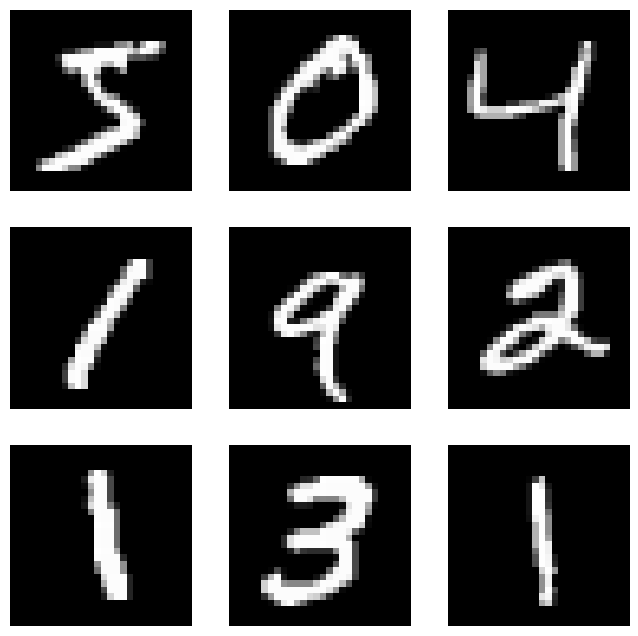

In [110]:
## Visualize the data
import matplotlib.pyplot as plt
import numpy as np

# show multiple images in a 
# grid format
fig, axs = plt.subplots(3, 3, figsize=(8,8))
for i in range(9):
    img = train_set[i]
    img = img * 0.5 + 0.5
    axs[i//3, i%3].imshow(img.view(*dimensions).permute(1,2,0), cmap='gray')
    axs[i//3, i%3].axis('off')


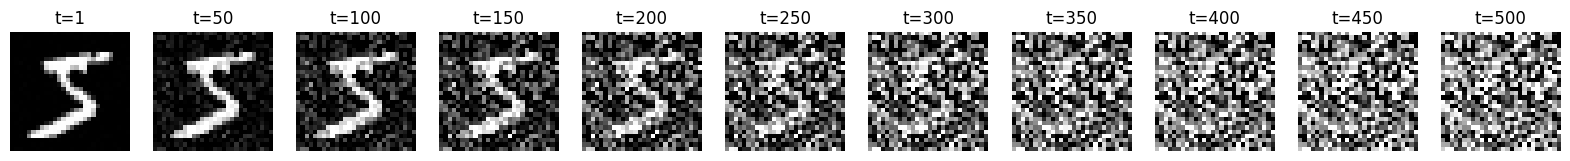

In [3]:
## make noisy images

from utils import NoiseSchedule

beta_start = 1e-4
beta_end = 0.02
T = 500
noise_schedule = NoiseSchedule(beta_start, beta_end, T)

fig, axs = plt.subplots(1, 11, figsize=(20, 2))
x0 = train_set[0].flatten()
ts = torch.linspace(0, T - 1, 11).view(-1, 1).long()
xts, _, _ = noise_schedule.make_noisy_images(x0, ts)
for i, t in enumerate(ts):
    img = xts[i].view(*dimensions).permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axs[i].imshow(img, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f't={t.item() + 1}')
plt.savefig("figures/noisy_images.png", dpi=300, bbox_inches='tight')
plt.show()


A better way of understanding the noise scheduling is to examine what happens to the value of a single pixel.
As seen below, the value of the pixel is approching 0 and the standard deviation is approaching 1. In other words, the pixel is becoming closer to a standard normal distribution. This is the goal of the noise scheduling. 
However, the distribution only approaches the standard normal distribution, it does not reach it. This is because the noise is not added to the pixel, but rather multiplied by the pixel. This means that the pixel will never reach 0, but rather approach it. The values of $\mu$ and $\sigma$ for each pixel distribution are shown below.

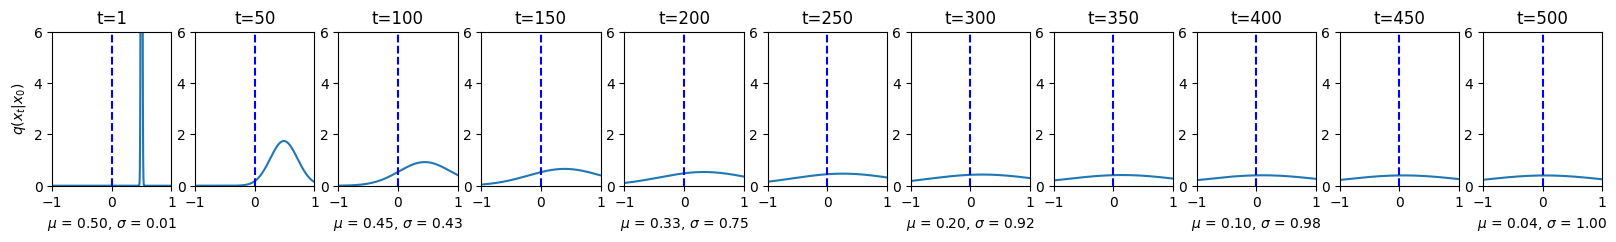

In [4]:
def normal_dist(x, mu, std):
    return 1 / (std * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * std**2))
pixel_value = 0.5
fig, axs = plt.subplots(1, 11, figsize=(20, 2))
mus = noise_schedule.sqrt_alpha_hat[ts]
stds = noise_schedule.sqrt_one_minus_alpha_hat[ts]
xx = torch.linspace(-2, 2, 1000)
for i, t in enumerate(ts):
    mu = mus[i] * pixel_value
    std = stds[i]
    axs[i].plot(xx, normal_dist(xx, mu, std))
    axs[i].set_title(f't={t.item() + 1}')
    axs[i].set_ylim(0, 6)
    axs[i].set_xlim(-1, 1)
    axs[i].axvline(0, color='b', linestyle='--')
    if i % 2 == 0:
        axs[i].set_xlabel("$\mu$ = {:.2f}, $\sigma$ = {:.2f}".format(round(mu.item(), 2), round(std.item(), 2)))
    if i == 0:
        axs[i].set_ylabel('$q(x_t | x_0)$')

plt.savefig("figures/pixel_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

To show that the distribution of the final layer actually approaches a standard normal distribution, we've plotted the KL-divergence between each layer and a standard normal. The KL-divergence clearly approaches 0. 

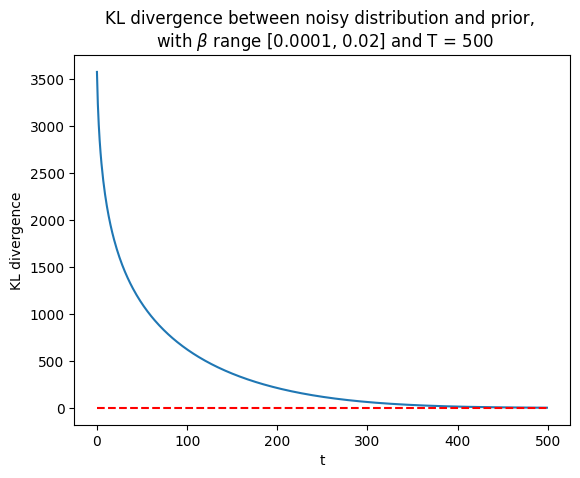

In [5]:
from tqdm import tqdm

## this small image is just a 10x10 patch of the original image

KL_list = np.zeros(T)
for t in range(T):
    mu = noise_schedule.sqrt_alpha_hat[t] * x0.flatten()
    std = noise_schedule.sqrt_one_minus_alpha_hat[t]

    k1 = img_size * std ** 2
    k2 = torch.sum(mu ** 2)
    k3 = - 2 * img_size * torch.log(std)
    kl = 1/2 * (k1 + k2 + k3 - img_size)
    
    KL_list[t] = kl.detach().numpy()

plt.plot(KL_list)
txt = "KL divergence between noisy distribution and prior, \n with " + r"$\beta$" + " range [0.0001, 0.02] and T = {}"
plt.title(txt.format(T))
plt.xlabel("t")
plt.ylabel("KL divergence")
plt.hlines(0, 0, T, color='r', linestyle='--')
plt.show()


We somehow have to encode the different timesteps. Here, we'll use sinusoidal encoding. 


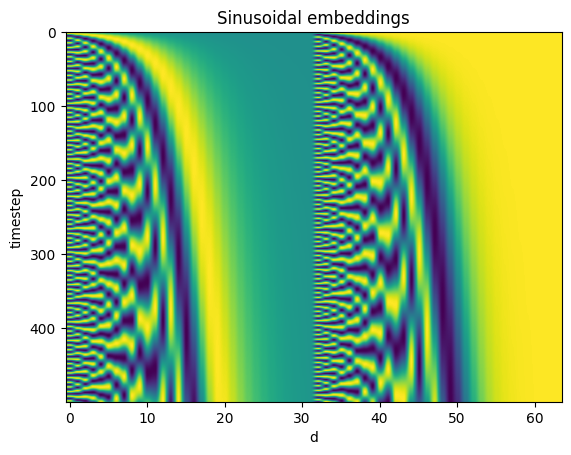

In [6]:
from utils import SinusoidalEmbeddings

ts = np.arange(0, T)
embeddings = SinusoidalEmbeddings(torch.tensor(ts).float())
plt.imshow(embeddings, cmap='viridis', aspect='auto')
plt.ylabel("timestep")
plt.xlabel("d")
plt.title("Sinusoidal embeddings")
plt.savefig("figures/sinusoidal_embeddings.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
from utils import SimpleModel, ResNET
import torch.nn as nn
mse = nn.MSELoss()

network_args = [dimensions[0], 64, [64,128,256]]
simple_network = ResNET(*network_args).to(device)
args = [simple_network, train_loader, noise_schedule, dimensions, device]
simple_model = SimpleModel(*args)
simple_model.load_model()

Model loaded from ../models/simple_model.pt


In [8]:
def sample_and_show_image(model, title="Sampled image"):
    xt = model.sample()
    xt = (xt - xt.min()) / (xt.max() - xt.min())
    img = xt.view(*dimensions).permute(1, 2, 0).cpu().numpy()
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [14]:
def training_loop(model, epochs):
    optimizer = torch.optim.Adam(model.parameters())
    epoch_loss = np.zeros(epochs)

    num_paramters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    parameters = np.zeros((epochs, num_paramters))

    for epoch in range(epochs):
        losses = torch.zeros(len(train_loader))

        for i, x0 in enumerate(tqdm(train_loader)):
            loss = model.loss(x0)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses[i] = loss.item()


        print(f"Epoch: {epoch}")
        print(losses.mean().item())
        # sample_and_show_image(model, "Epoch {}".format(epoch))
        model.save_model()
        epoch_loss[epoch] = losses.mean().item()

        curr_params = np.concatenate([p.detach().cpu().numpy().flatten() for p in model.parameters() if p.requires_grad])
        parameters[epoch] = curr_params
    
    return epoch_loss, parameters

In [15]:
simple_model_losses, simple_model_parameters = training_loop(simple_model, 20)
np.save("../data/simple_model_losses.npy", simple_model_losses)
np.save("../data/simple_model_parameters.npy", simple_model_parameters)

100%|██████████| 156/156 [00:22<00:00,  7.00it/s]


Epoch: 0
0.03714594617486
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:21<00:00,  7.10it/s]


Epoch: 1
0.035844285041093826
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.95it/s]


Epoch: 2
0.035971131175756454
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.97it/s]


Epoch: 3
0.035402562469244
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.91it/s]


Epoch: 4
0.03540778160095215
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  7.00it/s]


Epoch: 5
0.03511663153767586
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.81it/s]


Epoch: 6
0.03566233068704605
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.93it/s]


Epoch: 7
0.035484883934259415
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.95it/s]


Epoch: 8
0.035290732979774475
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  7.07it/s]


Epoch: 9
0.03473357483744621
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  7.06it/s]


Epoch: 10
0.03476733714342117
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.96it/s]


Epoch: 11
0.03502311930060387
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.87it/s]


Epoch: 12
0.034973613917827606
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.97it/s]


Epoch: 13
0.03502494469285011
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  7.09it/s]


Epoch: 14
0.034751903265714645
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.98it/s]


Epoch: 15
0.03498571366071701
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.95it/s]


Epoch: 16
0.03398660942912102
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:21<00:00,  7.35it/s]


Epoch: 17
0.034867193549871445
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:21<00:00,  7.10it/s]


Epoch: 18
0.034112412482500076
Model saved to ../models/simple_model.pt


100%|██████████| 156/156 [00:21<00:00,  7.13it/s]


Epoch: 19
0.034230224788188934
Model saved to ../models/simple_model.pt


Failed to load model from ../models/mu_model.pt
Initializing new model


100%|██████████| 156/156 [00:25<00:00,  6.23it/s]


Epoch: 0
0.12548303604125977
Sampling image..


100%|██████████| 499/499 [00:03<00:00, 144.52it/s]


Done sampling image


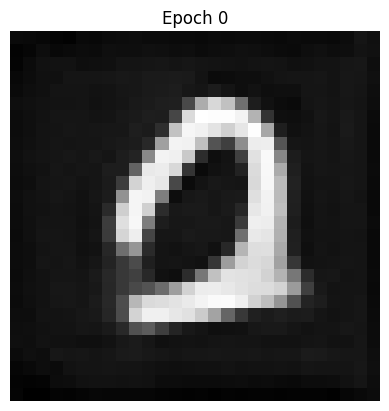

Model saved to ../models/mu_model.pt


100%|██████████| 156/156 [00:25<00:00,  6.12it/s]


Epoch: 1
0.11078061908483505
Sampling image..


100%|██████████| 499/499 [00:03<00:00, 140.40it/s]

Done sampling image


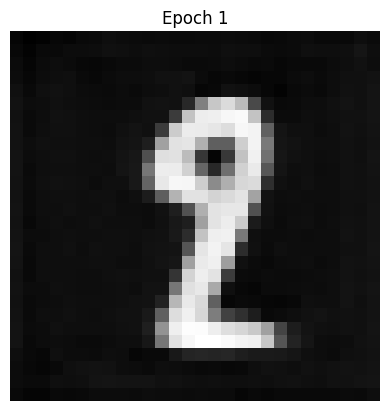

Model saved to ../models/mu_model.pt


100%|██████████| 156/156 [00:25<00:00,  6.14it/s]


Epoch: 2
0.11165923625230789
Sampling image..


100%|██████████| 499/499 [00:03<00:00, 152.29it/s]


Done sampling image


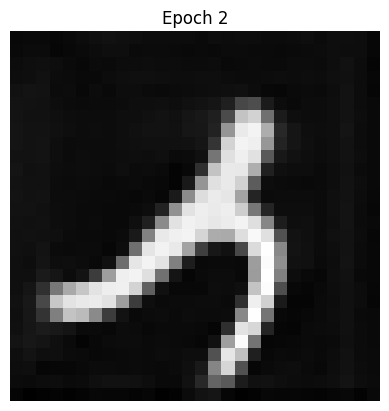

Model saved to ../models/mu_model.pt


100%|██████████| 156/156 [00:24<00:00,  6.35it/s]


Epoch: 3
0.10952907800674438
Sampling image..


100%|██████████| 499/499 [00:03<00:00, 146.44it/s]

Done sampling image


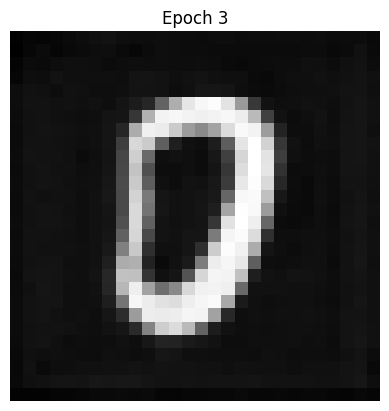

Model saved to ../models/mu_model.pt


100%|██████████| 156/156 [00:26<00:00,  5.82it/s]


Epoch: 4
0.10784313082695007
Sampling image..


100%|██████████| 499/499 [00:05<00:00, 92.90it/s] 


Done sampling image


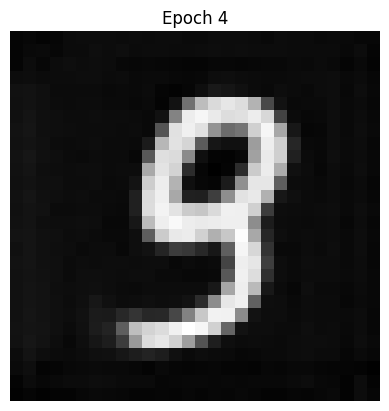

Model saved to ../models/mu_model.pt


100%|██████████| 156/156 [00:23<00:00,  6.68it/s]


Epoch: 5
0.10830722749233246
Sampling image..


100%|██████████| 499/499 [00:03<00:00, 146.50it/s]


Done sampling image


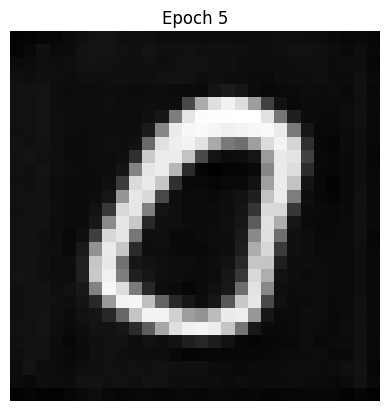

Model saved to ../models/mu_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.85it/s]


Epoch: 6
0.10734646022319794
Sampling image..


100%|██████████| 499/499 [00:03<00:00, 137.03it/s]


Done sampling image


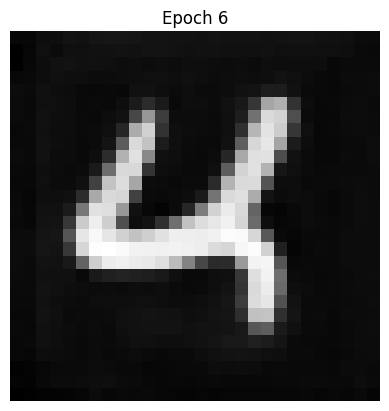

Model saved to ../models/mu_model.pt


100%|██████████| 156/156 [00:22<00:00,  6.88it/s]


Epoch: 7
0.10572010278701782
Sampling image..


100%|██████████| 499/499 [00:02<00:00, 170.33it/s]

Done sampling image


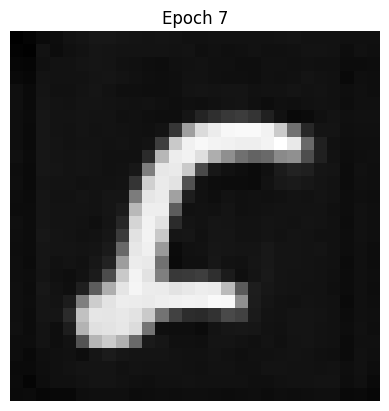

Model saved to ../models/mu_model.pt


100%|██████████| 156/156 [00:23<00:00,  6.65it/s]


Epoch: 8
0.10592454671859741
Sampling image..


100%|██████████| 499/499 [00:03<00:00, 166.32it/s]

Done sampling image


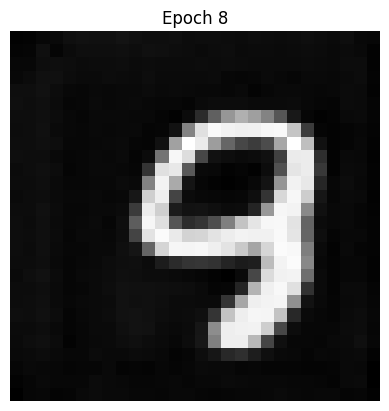

Model saved to ../models/mu_model.pt


100%|██████████| 156/156 [00:23<00:00,  6.75it/s]


Epoch: 9
0.10774597525596619
Sampling image..


100%|██████████| 499/499 [00:03<00:00, 164.05it/s]


Done sampling image


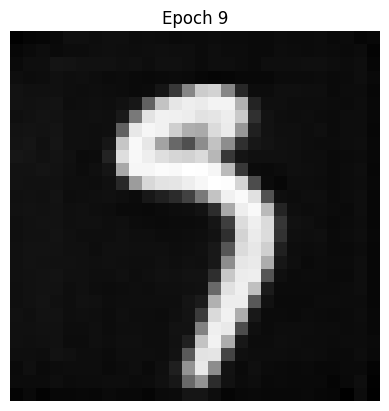

Model saved to ../models/mu_model.pt


In [13]:
from utils import MuModel
mu_network = ResNET(*network_args).to(device)
args = [mu_network, train_loader, noise_schedule, dimensions, device]
mu_model = MuModel(*args)
mu_model.load_model()

mu_model_losses, mu_model_parameters = training_loop(mu_model, 20)
np.save("../data/mu_model_losses.npy", mu_model_losses)
np.save("../data/mu_model_parameters.npy", mu_model_parameters)

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pca = PCA(n_components=2)

simple_model_parameters = np.load("../data/simple_model_parameters.npy")
simple_model_parameters = scaler.fit_transform(simple_model_parameters)
pca.fit(simple_model_parameters)

PCA(n_components=2)

In [75]:
def make_state_dict_from_paramters(model, parameters):
    state_dict = model.state_dict()
    start = 0
    for name, param in model.named_parameters():
        if param.requires_grad:
            end = start + param.numel()
            state_dict[name] = parameters[start:end].view(param.shape).to(device)
            start = end
    return state_dict

900it [02:47,  5.37it/s]


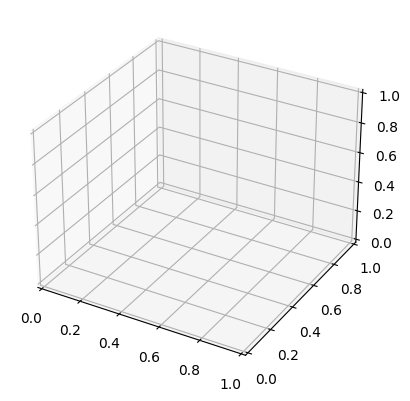

In [113]:
from mpl_toolkits import mplot3d

temp_network = ResNET(*network_args).to(device)
temp_model = SimpleModel(temp_network, train_loader, noise_schedule, dimensions, device)
resolution = 30
xx, yy = np.meshgrid(np.linspace(-3, 3, resolution), np.linspace(-3, 3, resolution))
zz = np.zeros_like(xx.flatten())

for i, (x, y) in tqdm(enumerate(zip(xx.flatten(), yy.flatten()))):
    params = np.array([x, y])
    params = pca.inverse_transform(params)
    params = scaler.inverse_transform(params.reshape(1, -1))
    params = torch.from_numpy(params).float().to(device)
    state_dict = make_state_dict_from_paramters(temp_model, params[0])
    temp_model.load_state_dict(state_dict)
    x0 = train_set[:64].view(64, *dimensions)
    loss = temp_model.loss(x0).item()
    zz[i] = loss

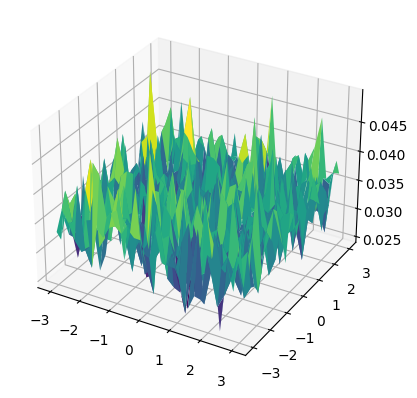

In [129]:
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, zz.reshape(resolution, resolution), cmap='viridis')